# Chapter 1: Greenhouses Gases - The prime suspect

### Generation of plots inspired by [the relevant Climate Indicators' report](https://climate.copernicus.eu/climate-indicators/greenhouse-gas-concentrations).

The ongoing climate change and the subsequent incease of earth's temperature is  a hot topic in the recent years, but expanded from the purely scientific communtiies and touches now almost all aspects of our lives. There is much said about the role that the GreenHouse Gases (GHG) play in this climatic crisis. Let's follow this tutorial and find out if and how the concentrations of two key GHG (carbon dioxide - CO2, and methan - CH4) changed in the last decades.

### Section 1. Installing & importing the necessary packages.

In [1]:
# CDS API
import cdsapi

# operating system interfaces library
import os

# general libraries
from string import ascii_lowercase as ABC # String operations
import datetime

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

# Library for working with 2-d arrays
import pandas as pd

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
# import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import matplotx
plt.style.use('copernicus.mplstyle') # use the predefined matplotlib style for consistent plotting across all tutorials

### Section 2. Downloading data from CDS and ADS.

In [2]:
dir_loc = 'data/' # assign folder for storing the downloaded data
os.makedirs(dir_loc, exist_ok=True) # create the folder if not available

In [3]:
# get one slice of land-sea mask from ERA5 data that will be used ater on for the GHG analysis.
# Note that the resolution (grid) should be specified, because the original one (0.25) is different that the resolution of GHG (0.75).

# If there is no ssh key for cds and aps stored in the machine, then the url and key should be explicitely stated on the cdsapi.Client()
# cds_url = 'https://cds.climate.copernicus.eu/api/v2'
# cds_key = 'YOUR_KEY' # please add your key here the format should be as {uid}:{api-key}
# c = cdsapi.Client(url=cds_url, key=cds_key)

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
     'product_type': 'reanalysis',
     'variable': 'land_sea_mask',
     'year': '2009',
     'month': '10',
     'day': '16',
     'time': '00:00',
     'grid': [0.75, 0.75],
     'format': 'netcdf',
    },
    f'{dir_loc}land_sea_mask.nc')

del(c)

2023-05-30 18:07:34,990 INFO Welcome to the CDS
2023-05-30 18:07:34,993 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-05-30 18:07:35,135 INFO Request is completed
2023-05-30 18:07:35,137 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data1/adaptor.mars.internal-1685441252.5321405-21463-17-e5d217f5-4d0b-48ab-a63c-a3bb7bc9ee70.nc to data/land_sea_mask.nc (229.9K)
2023-05-30 18:07:36,228 INFO Download rate 211.1K/s


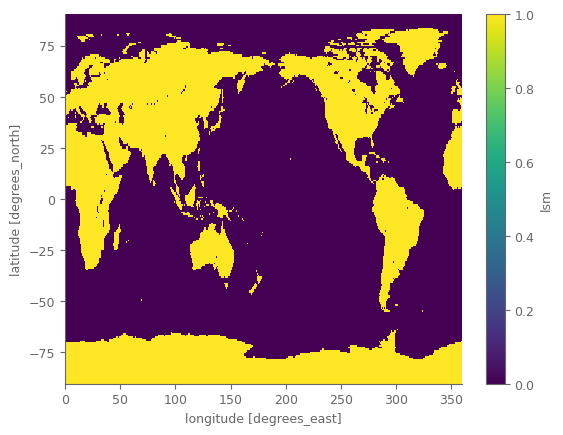

In [4]:
# read the land-sea mask and visualize ("quick and dirty") the data
data_mask = xr.open_dataarray(f'{dir_loc}land_sea_mask.nc').isel(time=0, drop=True)
is_land = data_mask >= 0.5 # make data boolean (1-land, 0-sea), and convert all cells with at least 50% land, as only land
is_land.plot()
del(data_mask)

In [5]:
# get monthly mean grennhouse gases data from Atmosphere Data Store (it takes around 2 minutes)
ads_url = 'https://ads.atmosphere.copernicus.eu/api/v2'
ads_key 'YOUR KEY' # please add your key here the format should be as {uid}:{api-key}
c = cdsapi.Client(url=ads_url, key=ads_key)
c.retrieve(
    'cams-global-ghg-reanalysis-egg4-monthly',
    {
     'product_type': 'monthly_mean',
     'variable': ['ch4_column_mean_molar_fraction', 'co2_column_mean_molar_fraction'], # get the available variables
     'year': list(range(2003, 2021)), # get all available years (2003, 2004, ..., 2020)
     'month': list(range(1, 13)), # get all months Jan (1) up to Dec (12)
     'format': 'netcdf',
    },
    f'{dir_loc}greenhouse_gases.nc')

del(ads_url, ads_key, c)

2023-05-30 18:07:38,000 INFO Welcome to the CDS
2023-05-30 18:07:38,004 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-ghg-reanalysis-egg4-monthly
2023-05-30 18:07:38,205 INFO Request is completed
2023-05-30 18:07:38,208 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.external-1683983665.986999-18127-5-994cf598-7b63-4f76-915e-6310a89f2575.nc to data/greenhouse_gases.nc (95.3M)
2023-05-30 18:09:54,251 INFO Download rate 717.5K/s 


In [6]:
# open the GHG data and inspect the Dataset
# when the data are opened as below using "with" then the link to the actual dataset is closed, meaning that any other program can also access the file in the directory
# this is not the case for the normal opening of the file, as for the data_mask
with xr.open_dataset(f'{dir_loc}greenhouse_gases.nc') as ghg:
    pass
ghg

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 216)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    tcch4      (time, latitude, longitude) float32 ...
    tcco2      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-13 13:14:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

As we can notice, the dataset is a 3-dimensional cube (latitude, longitude, time) with information for two variables (C02, CH4).

### Section 3. Calculating and plotting the quantities of interest.

#### Monthly mean quantities across land for 60N-60S latitudes. 

The data are projected in lat/lon system. This system does not have equal areas for all grid cells, but as we move closer to the poles, the area of the cells is reducing. These differences can be accounted when weighting the cells with the cosine of their latitude.

In [7]:
wgts = np.cos(np.deg2rad(ghg.latitude)).clip(0, 1) # coslat for weights on spatial averaging. 
wgts # the clip function above is for reassuring that all values will be between 0-1 regardless of the  of machine's precision

<xarray.DataArray 'latitude' (latitude: 241)>
array([0.        , 0.0130896 , 0.02617699, 0.03925979, 0.05233597,
       0.06540319, 0.07845908, 0.09150165, 0.10452842, 0.1175374 ,
       0.13052624, 0.1434926 , 0.15643449, 0.16934957, 0.18223551,
       0.19509035, 0.20791166, 0.22069745, 0.23344542, 0.24615327,
       0.25881907, 0.27144054, 0.28401536, 0.29654163, 0.30901697,
       0.32143947, 0.33380693, 0.34611705, 0.35836798, 0.3705574 ,
       0.38268346, 0.39474392, 0.4067366 , 0.41865978, 0.43051115,
       0.4422887 , 0.45399055, 0.4656145 , 0.47715878, 0.48862126,
       0.49999997, 0.5112931 , 0.5224986 , 0.5336145 , 0.54463905,
       0.55557024, 0.56640625, 0.57714516, 0.58778524, 0.5983246 ,
       0.6087614 , 0.61909395, 0.6293204 , 0.639439  , 0.64944804,
       0.6593458 , 0.66913056, 0.67880076, 0.68835455, 0.69779044,
       0.70710677, 0.716302  , 0.72537434, 0.7343225 , 0.7431448 ,
       0.7518398 , 0.76040596, 0.7688418 , 0.777146  , 0.78531694,
       0.7933533 , 0.8012538 , 0.809017  , 0.81664157, 0.8241262 ,
       0.8314696 , 0.83867055, 0.8457278 , 0.85264015, 0.8594064 ,
       0.8660254 , 0.872496  , 0.87881714, 0.88498765, 0.8910065 ,
       0.89687276, 0.90258527, 0.90814316, 0.9135454 , 0.91879123,
       0.9238795 , 0.9288095 , 0.9335804 , 0.93819135, 0.9426415 ,
       0.9469301 , 0.95105654, 0.95501995, 0.95881975, 0.9624552 ,
...
       0.9469301 , 0.9426415 , 0.93819135, 0.9335804 , 0.9288095 ,
       0.9238795 , 0.91879123, 0.9135454 , 0.90814316, 0.90258527,
       0.89687276, 0.8910065 , 0.88498765, 0.87881714, 0.872496  ,
       0.8660254 , 0.8594064 , 0.85264015, 0.8457278 , 0.83867055,
       0.8314696 , 0.8241262 , 0.81664157, 0.809017  , 0.8012538 ,
       0.7933533 , 0.78531694, 0.777146  , 0.7688418 , 0.76040596,
       0.7518398 , 0.7431448 , 0.7343225 , 0.72537434, 0.716302  ,
       0.70710677, 0.69779044, 0.68835455, 0.67880076, 0.66913056,
       0.6593458 , 0.64944804, 0.639439  , 0.6293204 , 0.61909395,
       0.6087614 , 0.5983246 , 0.58778524, 0.57714516, 0.56640625,
       0.55557024, 0.54463905, 0.5336145 , 0.5224986 , 0.5112931 ,
       0.49999997, 0.48862126, 0.47715878, 0.4656145 , 0.45399055,
       0.4422887 , 0.43051115, 0.41865978, 0.4067366 , 0.39474392,
       0.38268346, 0.3705574 , 0.35836798, 0.34611705, 0.33380693,
       0.32143947, 0.30901697, 0.29654163, 0.28401536, 0.27144054,
       0.25881907, 0.24615327, 0.23344542, 0.22069745, 0.20791166,
       0.19509035, 0.18223551, 0.16934957, 0.15643449, 0.1434926 ,
       0.13052624, 0.1175374 , 0.10452842, 0.09150165, 0.07845908,
       0.06540319, 0.05233597, 0.03925979, 0.02617699, 0.0130896 ,
       0.        ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
Attributes:
    units:      degrees_north
    long_name:  latitude

In [8]:
# get global average for selected subdomain of latitudes, when considering only land data
used_latitudes = slice(60, -60) # note that the latitude coordinates on the ghg dataset are in decreasing order, and this should be respected!

ghg_land = ghg.where(is_land) # keep only land data
ghg_land = ghg_land.sel(latitude=used_latitudes) # use only selected domain
spatial_average = ghg_land.weighted(wgts).mean(['latitude', 'longitude']).assign_coords({'type': 'monthly'}) # spatial average weighted due to areal differences of the grid cells

# get smoothed global values
smoothed_n_months = 12 # define the number of months used for the temporal smoothing (in this case we use 12 months)

spatial_average_smoothed = spatial_average.rolling(time=smoothed_n_months, min_periods=1, center=True).mean()
spatial_average_smoothed = spatial_average_smoothed.assign_coords({'type': f'{smoothed_n_months}-month smoothed'}) # smoothed n-month spatial average

spatial_average = xr.concat([spatial_average, spatial_average_smoothed], dim='type') # combine the actual and smoothed data in one dataset

del(ghg_land, spatial_average_smoothed)

Plot the timeseries of the global average monhtly concentrations of the GHG. 

In [9]:
# get the date that the CO2 concetrations exceeded 400 ppm for the first time
is_above_400 = spatial_average['tcco2'].sel(type='monthly') >= 400
idx_first_time_step_above_400 = is_above_400.argmax(dim='time', skipna=True)

first_time_400 = spatial_average['tcco2'].time.isel(time=idx_first_time_step_above_400).values
first_time_400 = pd.to_datetime(first_time_400)

In [10]:
# auxiliary data used for plotting
prop_cycle_clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

aux_var = {
    'tcco2': {'name':'Atmospheric carbon dioxide', 'units': 'ppm', 'shortname': r'CO$_{2}$', 'color': prop_cycle_clrs[0]},
    'tcch4': {'name':'Atmospheric methane', 'units': 'ppb', 'shortname': r'CH$_{4}$', 'color': prop_cycle_clrs[1]},
}

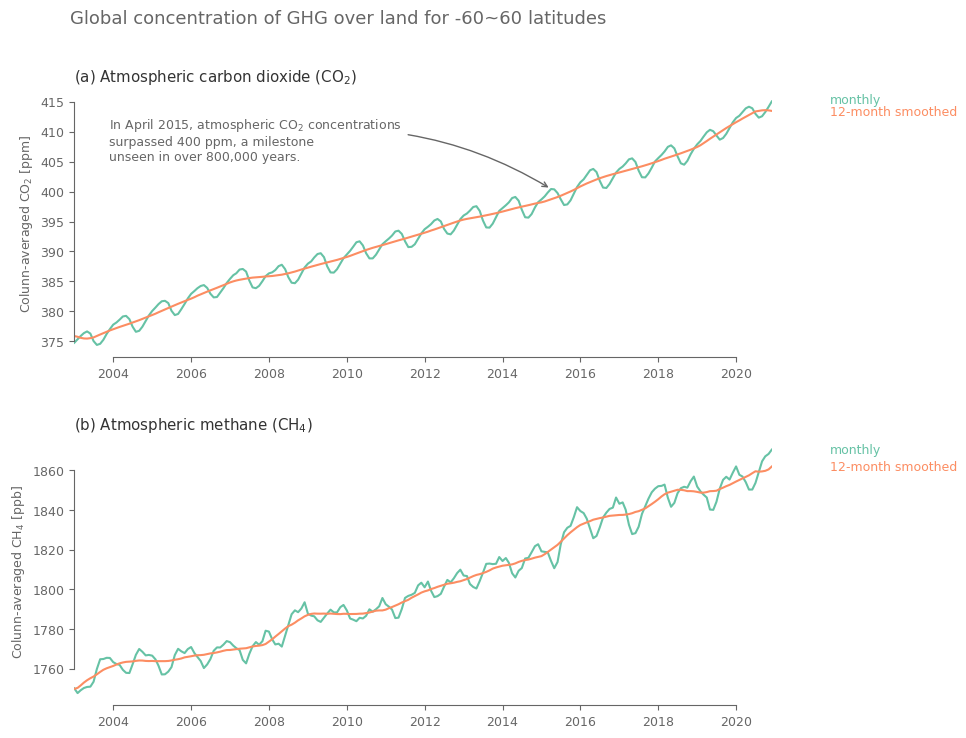

In [11]:
subtitles = ['CO$_2$ (ppm/year)', 'CH$_4$ (ppb/year)']

fig, ax = plt.subplots(2, 1, figsize=(9, 8)) # one subplot for each GHG
ax = ax.flatten()

for i, i_ghg in enumerate(['tcco2', 'tcch4']): # iterate through the GHG
  
    yy_all = [spatial_average[i_ghg].sel(type=i_type).values for i_type in spatial_average.type.values]
    for yy, label in zip(yy_all, spatial_average.type.values):
        ax[i].plot(spatial_average.time.values, yy, label=label) 

    matplotx.line_labels(ax=ax[i]) # add legend as colored text next to the right end of the relevant line

    ax[i].set_xlim(spatial_average[i_ghg].time.values[0], spatial_average[i_ghg].time.values[-1])
    ax[i].set_title(f'({ABC[i]}) ' + aux_var[i_ghg]['name'] + ' (' + aux_var[i_ghg]['shortname'] + ')')
    ax[i].set_ylabel('Colunn-averaged '+ aux_var[i_ghg]['shortname']  + ' [' + aux_var[i_ghg]['units'] + ']')

    sns.despine(ax=ax[i], trim=True) # trimming the y and x axis to be visible only from the fist till the last tick
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # the formatting is needed because the above line breaks the time format of the x axis
    if i_ghg=='tcco2':
        # Place a text in the first axis with an arrow pointing to the maximum value in axis 0
        desc = 'In ' + first_time_400.strftime('%B %Y') + ', atmospheric CO$_2$ concentrations \nsurpassed 400 ppm, a milestone \nunseen in over 800,000 years.'
        ax[i].annotate(
                        desc,
                        xy=(first_time_400, spatial_average['tcco2'].sel(type='monthly', time=first_time_400).values),
                        xytext=(0.05, 0.9),
                        textcoords=ax[i].transAxes,
                        ha='left', va='top',
                        arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
                      )

fig.suptitle(f'Global concentration of GHG over land for {used_latitudes.stop}~{used_latitudes.start} latitudes', horizontalalignment='left', x=.12)
plt.subplots_adjust(hspace=.3)

del(fig, ax, i, i_ghg, yy_all, yy, label, desc, first_time_400, is_above_400, idx_first_time_step_above_400, subtitles, used_latitudes)

The above plot shows a clear increasing trend in the concentrations of the GHG for all years in the record. Moreover, it can be noticed that there is an evident seasonality for both GHG.

Let's now quantify and visualize how the growth rate changes per year (at annual scales). Because of the clear seasonality of the concentrations we will not use the original data, but the smoothed ones.

In [12]:
growth_rate = spatial_average.diff('time') # get the difference from the next to the previous month
growth_rate = growth_rate.isel(type=1, drop=True) # keep the smoothed timeseries
monthly_growth_rate_mean = growth_rate.groupby('time.year').mean()
monthly_growth_rate_stdev = growth_rate.groupby('time.year').std()

annual_growth_rate_mean = 12 * monthly_growth_rate_mean
annual_growth_rate_stdev = np.sqrt(12 * monthly_growth_rate_stdev**2) # quadratic summation of the monthly standard deviations

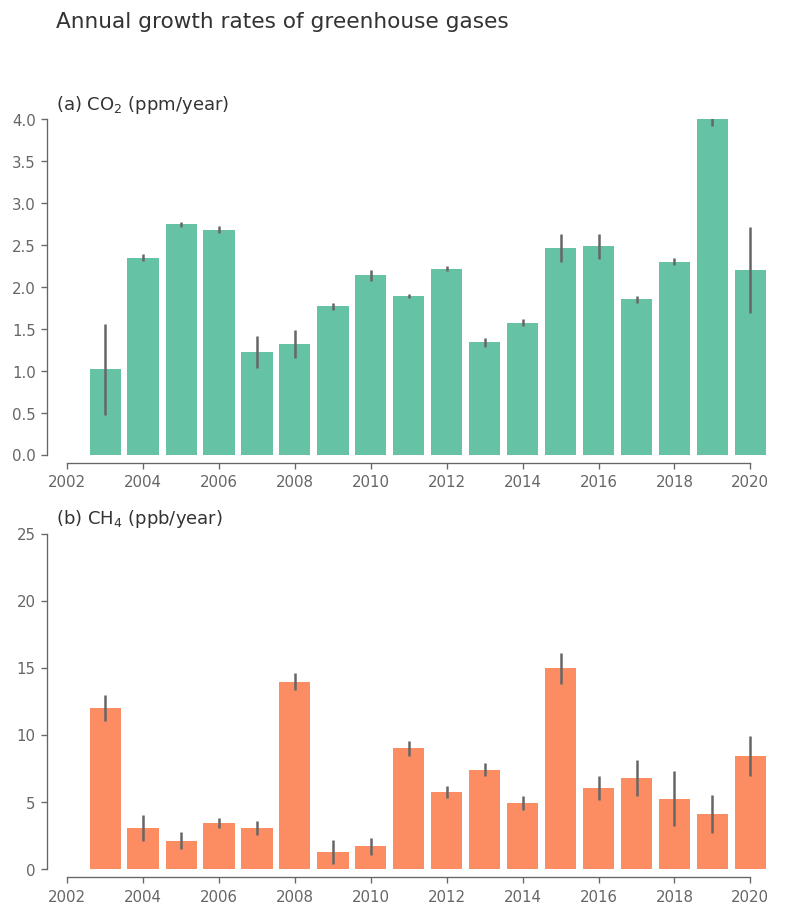

In [13]:
subtitles = ['CO$_2$ (ppm/year)', 'CH$_4$ (ppb/year)']

fig = plt.figure(figsize=(8, 9), dpi=120)
gs = GridSpec(3, 1, figure=fig, height_ratios=[.01, 1, 1], hspace=0.35)

tax = fig.add_subplot(gs[0, 0])
axes = [fig.add_subplot(gs[i, 0]) for i in range(1, 3)]

years = pd.to_datetime(annual_growth_rate_mean.year.values, format='%Y')

axes[0].set_ylim(0, 4)
axes[1].set_ylim(0, 25)
for ax, abc, molecule, title in zip(axes, ABC, ['tcco2', 'tcch4'], subtitles):
    ax.bar(years, annual_growth_rate_mean[molecule], width=datetime.timedelta(days=300), color=aux_var[molecule]['color'])
    ax.errorbar(years, annual_growth_rate_mean[molecule], yerr=annual_growth_rate_stdev[molecule], ls='', color='.4')
    ax.set_title(f'({abc}) ' + title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    sns.despine(ax=ax, trim=True, offset=5)
tax.axis('off')
tax.set_title('Annual growth rates of greenhouse gases', fontsize='x-large')

del(subtitles, fig, ax, gs, tax, axes, years, abc, molecule, title, growth_rate, monthly_growth_rate_stdev,
    monthly_growth_rate_mean, annual_growth_rate_stdev, annual_growth_rate_mean)

The rate of increase is quite varying across the years. Note that for the first and last year the results are not that reliable because the smoothed data that were used don't have all necessary values (the values are based on centered data, thus by default the few first and last values are not using all data needed for the correct smoothing).

So far we have seen that there is indeed an increasing trend for both variables, while both of them have differences in the seasonal cycle and the annual growth rate.

Let's now compare the behaviour across both variables. Since the values are of substantially different magnitude, we first need to normalize the data for being able to plot them on same plot.

<div class="alert alert-block alert-success">
<b>NOTE</b> <br>Here we will use a simple normalization based on global mean and standard deviation. For the ones interested further, there is a small appendix demonstrating why considering anomalies based on monthly climatology, a method commonly used for other environmental variables, is not the best option in our case.</a></div>

In [14]:
anomalies = (spatial_average-spatial_average.mean('time'))/spatial_average.std('time')

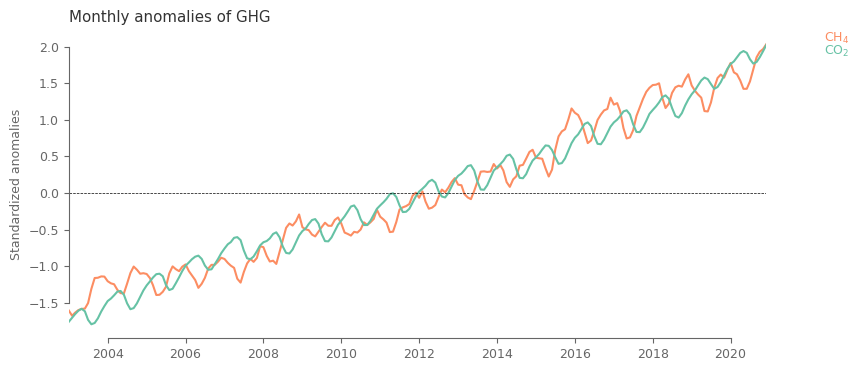

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

label_all = [aux_var[i]['shortname'] for i in list(anomalies.keys())]
color_all = [aux_var[i]['color'] for i in list(anomalies.keys())]
yy_all = [anomalies[i_var].sel(type='monthly').values for i_var in anomalies.keys()]
for yy, label, color in zip(yy_all, label_all, color_all):
    ax.plot(anomalies.time.values, yy, label=label, color=color)      
matplotx.line_labels(ax=ax) # add legend as colored text next to the right end of the relevant line

ax.axhline(0, color='k', ls='--', lw=0.5)
ax.set_xlim(anomalies.time.values[0], anomalies.time.values[-1])
ax.set_title('Monthly anomalies of GHG')
ax.set_ylabel('Standardized anomalies')
sns.despine(ax=ax, trim=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

del(fig, ax, label_all, color_all, yy_all, yy, label, color, anomalies)

After the simple normalization it seems that the main differences between the two variables lie in the seasonal cycle, which is shifted.

THe above analysis covers a large part of the globe, which does not give us the opportunity to access spatial differences. For the last part of the GHG analysis, let's do a spatial refinement and understand how the concentrations evolve in the northern vs southern hemisphere.

In [16]:
studied_domains = {
                  'Global': {'latitude': slice(90, -90)},
                  'Northern Hemishpere': {'latitude': slice(90, 0)},
                  'Southern Hemisphere': {'latitude': slice(0, -90)}
                  }

In [17]:
mean_domains = []
for i, domain in studied_domains.items(): # iterate through the domains
    i_data_subset = ghg.where(is_land).sel(domain) # keep only land data over the domain of interest
    i_spatial_average = i_data_subset.weighted(wgts).mean(['latitude', 'longitude']) # spatial average
    mean_domains.append( i_spatial_average.assign_coords({'domain': i}) )

mean_domains = xr.concat(mean_domains, dim='domain')

# all the above can be also written in 2 lines based on list-comprehension as below
mean_domains = [ghg.where(is_land).sel(domain).weighted(wgts).mean(['latitude', 'longitude']) for domain in studied_domains.values()]
mean_domains = xr.concat(mean_domains, dim=pd.Index(studied_domains.keys(), name='domain'))

del(i, domain, i_data_subset, i_spatial_average, studied_domains)

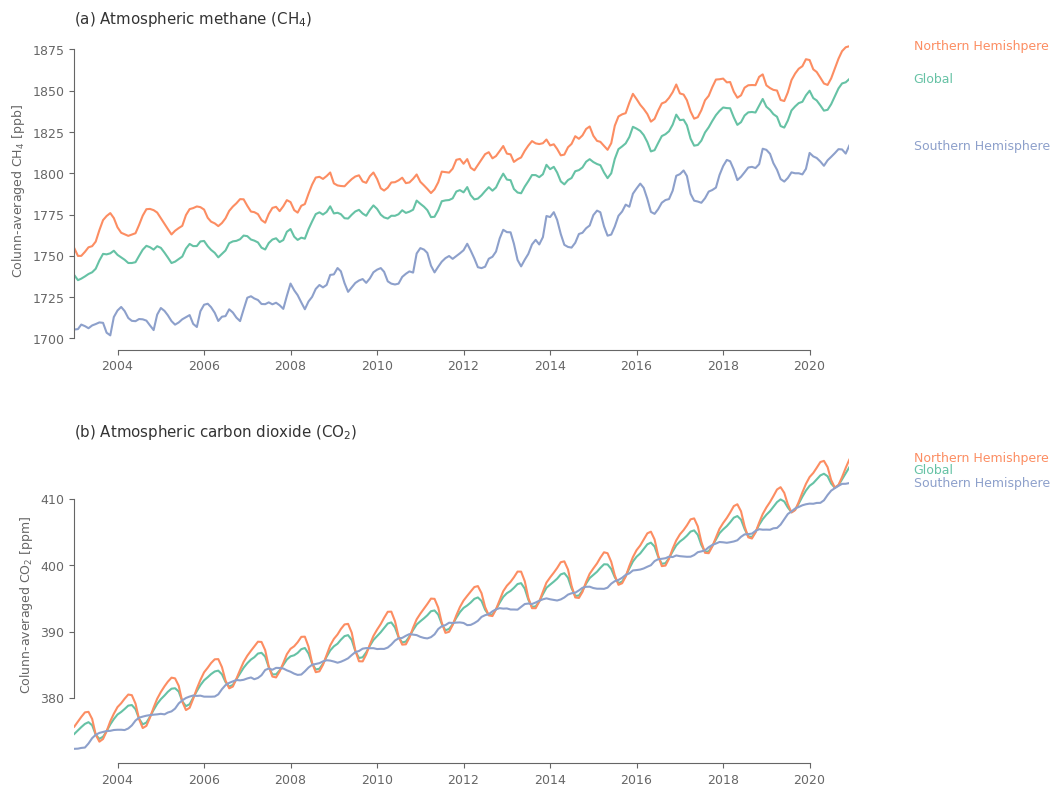

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9.5))
ax = ax.flatten()
for i, j in enumerate(mean_domains.keys()):
    
    yy_all = [mean_domains[j].sel(domain=i_dom).values for i_dom in mean_domains.domain.values]
    for yy, label in zip(yy_all, mean_domains.domain.values):
        ax[i].plot(mean_domains.time.values, yy, label=label) 
    matplotx.line_labels(ax=ax[i]) # add legend as colored text next to the right end of the relevant line

    ax[i].set_xlim(mean_domains[j].time.values[0], mean_domains[j].time.values[-1])
    ax[i].set_title(f'({ABC[i]}) '+ aux_var[j]['name'] + ' (' + aux_var[j]['shortname'] + ')')
    ax[i].set_ylabel('Colunn-averaged '+ aux_var[j]['shortname']  + ' [' + aux_var[j]['units'] + ']')

    sns.despine(ax=ax[i], trim=True) # trimming the y and x axis to be visible only from the fist till the last tick
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # the formatting is needed because the above line breaks the time format of the x axis

plt.subplots_adjust(hspace=.3)
del(fig, ax, i, j, yy_all, yy, label, mean_domains)

The methane (CH4) has a clear differentiation in the concentrations between the two hemispheres. CO2 shows no seasonality for the southern hemisphere. Can it be because we only use land, and land mass in the southern hemisphere is substantially smaller compared to northern?

For both variables the northern hemisphere has the most impact in defining the global mean. What could be possible reasons for that? The larger land mass of northern hemisphere? Or maybe the fact that most of the global population and industrial activities lie in that hemisphere?

### Section 4. Useful links
For the ones interested in finding out more about GHG, please find below some links for relevant articles and visualizations:
1. [Greenhouse gas concentrations Climate Indicators Report](https://climate.copernicus.eu/climate-indicators/greenhouse-gas-concentrations)
2. [Global Monitorin Laboratory](https://gml.noaa.gov/ccgg/) from [NOAA](https://www.noaa.gov/), with a lot of information, relevant plots, and raw data that can be freely donwloaded. 
3. Lashof, D., Ahuja, D. Relative contributions of greenhouse gas emissions to global warming. Nature 344, 529–531 (1990). https://doi.org/10.1038/344529a0

### Section 5. Appendix - Monthly climatology of the variables
As we stated previously, we only used global mean and standard deviation for comparing both variables, and we did not use monthly climatology. Let's see how the monthly climatology looks like, and why using it is not the best approach.

In [19]:
# what is normally done assuming a 'stationary' behaviour of the variable
climatology_mean = spatial_average.groupby('time.month').mean('time') # climatological mean for each month
climatology_std = spatial_average.groupby('time.month').std('time') # climatological standard deviation for each month
anomalies = (spatial_average.groupby('time.month') - climatology_mean)
anomalies = anomalies.groupby('time.month')/climatology_std

del(climatology_std)

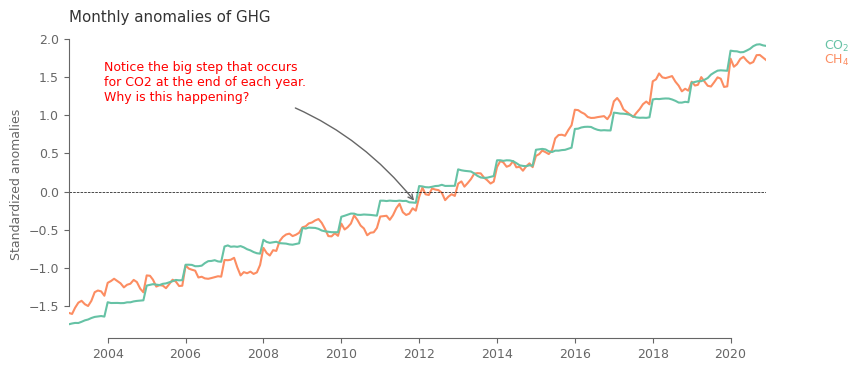

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

label_all = [aux_var[i]['shortname'] for i in list(anomalies.keys())]
color_all = [aux_var[i]['color'] for i in list(anomalies.keys())]
yy_all = [anomalies[i_var].sel(type='monthly').values for i_var in anomalies.keys()]
for yy, label, color in zip(yy_all, label_all, color_all):
    ax.plot(anomalies.time.values, yy, label=label, color=color)      
matplotx.line_labels(ax=ax) # add legend as colored text next to the right end of the relevant line

ax.axhline(0, color='k', ls='--', lw=0.5)
ax.set_xlim(anomalies.time.values[0], anomalies.time.values[-1])
ax.set_title('Monthly anomalies of GHG')
ax.set_ylabel('Standardized anomalies')
sns.despine(ax=ax, trim=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

date_annotate = pd.to_datetime('201112', format='%Y%m')
ax.annotate(
            'Notice the big step that occurs \nfor CO2 at the end of each year.\nWhy is this happening?',
            xy=(date_annotate, anomalies['tcco2'].sel(type='monthly', time=date_annotate).values),
            xytext=(0.05, 0.9),
            textcoords=ax.transAxes,
            ha='left', va='top', color='red',
            arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
           )


del(fig, ax, label_all, color_all, yy_all, yy, label, color, date_annotate, anomalies)

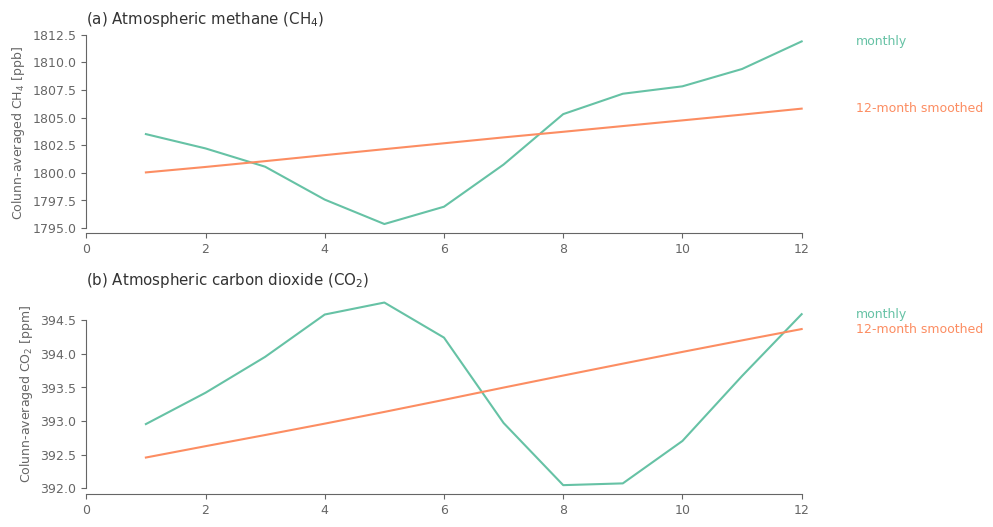

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

for i, j in enumerate(climatology_mean.keys()):

    yy_all = [climatology_mean[j].sel(type=i_typ).values for i_typ in climatology_mean.type.values]
    for yy, label in zip(yy_all, climatology_mean.type.values):
        ax[i].plot(climatology_mean.month.values, yy, label=label) 
    matplotx.line_labels(ax=ax[i]) # add legend as colored text next to the right end of the relevant line    
    
    ax[i].set_xlim(0, 13)

    ax[i].set_title(f'({ABC[i]}) '+ aux_var[j]['name'] + ' (' + aux_var[j]['shortname'] + ')')
    ax[i].set_ylabel('Colunn-averaged '+ aux_var[j]['shortname']  + ' [' + aux_var[j]['units'] + ']')

    sns.despine(ax=ax[i], trim=True) # trimming the y and x axis to be visible only from the fist till the last tick

plt.subplots_adjust(hspace=.3)
del(fig, ax, i, j, yy_all, yy, label)

Maybe its more useful to present the results in polar coordinates, since from a climatological point of view the months follow a circular behaviour with December being similar to January.

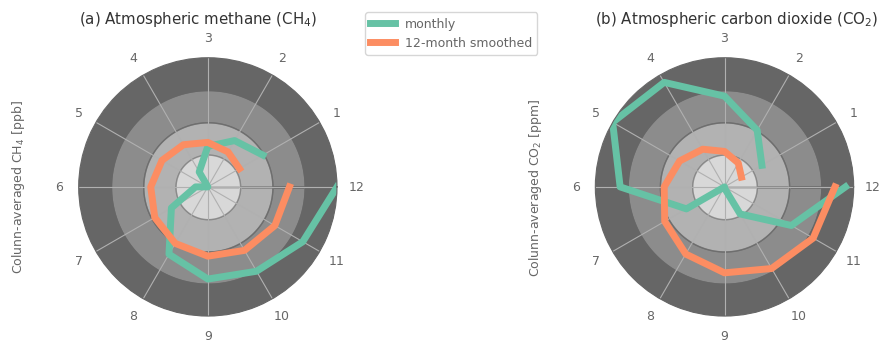

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, j in enumerate(climatology_mean.keys()):

    yy_all = [climatology_mean[j].sel(type=i_typ).values for i_typ in climatology_mean.type.values]
    for yy, label in zip(yy_all, climatology_mean.type.values):
        ax[i].plot((climatology_mean.month.values)/12*2*np.pi, yy, label=label, linewidth=5) 
    
    # color the graph based on y value for easily differentiating between the magnitudes for the months
    segments = np.linspace(np.array(yy_all).min()*1, np.array(yy_all).max()*1., 5)
    for seg_min, seg_max, i_alpha in zip(segments[:-1], segments[1:], np.arange(0.25, 1.01, .25)):
        ax[i].fill_between(x=np.linspace(0, 2*np.pi, 360), y1=seg_max, y2=seg_min, color='.4', alpha=i_alpha)

    ax[i].set_ylim(np.array(yy_all).min()*1, np.array(yy_all).max()*1.)
    
    ax[i].set_xticks((climatology_mean.month.values)/12*2*np.pi)
    ax[i].set_xticklabels(range(1, 13))
    ax[i].set_yticks([])
    ax[i].set_title(f'({ABC[i]}) '+ aux_var[j]['name'] + ' (' + aux_var[j]['shortname'] + ')')
    ax[i].yaxis.set_label_coords(-0.2, 1)
    ax[i].set_ylabel('Colunn-averaged '+ aux_var[j]['shortname']  + ' [' + aux_var[j]['units'] + ']')
    if i==1: ax[i].legend(bbox_to_anchor=(-.2, 1.2))

plt.subplots_adjust(wspace=1)
del(fig, ax, i, j, yy_all, yy, label, segments, seg_min, seg_max, i_alpha, climatology_mean)

Notice the difference in the values between January mean state and December mean state for both GHG (green lines), especially so for CO2. This indicates that on average just in the course of 1 single year there is already a substantial increase in the concentrations, that do alter the expected seasonal cycle, as we normally would expect to see the Jan and Dec values being very very close. Especially by checking the smoothed data (orange lines), the increasing trend of the mean state at each month is clearly evident.

Because of this substantial reduction in the mean state of January compared to Decembers we see the high jump for every January, as the climatological mean is small, thus the anomalies get large.

Thus, in order to get the anomalies in a more robust way that the ones used in the main part of this tutorial, we would not only need to remove the seasonal cycle, but also detrend the data!